<font size=4 color='cornflowerblue'>

# <center>Clase 11, diciembre 9 del 2020</center>

<font size=5 color="cornflowerblue">

Convolutional Neural Networks in 1D

<font size=4>

*CNNs work the same way whether they have 1, 2, or 3 dimensions. The difference is the structure of the input data and how the filter, also known as a convolution kernel or feature detector, moves across the data.*

[missinglink.ai: Keras Conv1D: Working with 1D Convolutional Neural Networks in Keras](https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/)

As in the conventional 2D CNNs, the input layer is a passive layer that receives the raw 1D signal and the output layer is a MLP layer with the number of neurons equal to the number of classes.  The main difference between 1D and 2D CNNs, where 1D arrays replace 2D matrices for both kernels and feature maps. As a next step, the CNN layers process the raw 1D data and “learn to extract” such features which are used in the classification task performed by the MLP-layers. As a consequence, both feature extraction and classification operations are fused into one process that can be optimized to maximize the classification performance. This is the major advantage of 1D CNNs which can also result in a low computational complexity since the only operation with a significant cost is a sequence of 1D convolutions which are simply linear weighted sums of two 1D arrays.

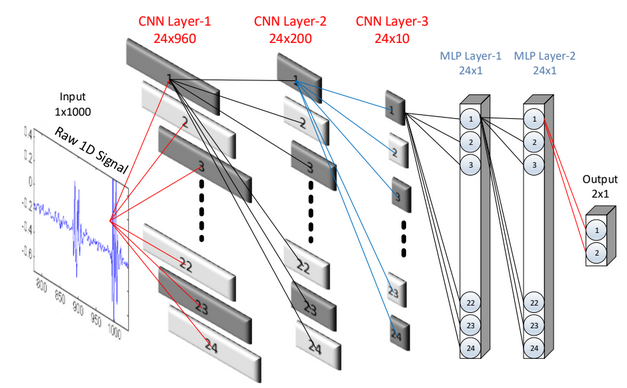


[1D Convolutional Neural Networks and Applications – A Survey](literatura/1DCNNandApplications–ASurvey.pdf)

Some applications of CNN 1D are:

[1D Convolutional Neural Network Models for
Sleep Arousal Detection](literatura/1DCNNModelsforSleepArousalDetection.pdf)

[A classification method for judging the depth of
chest compression based on CNN
](literatura/AclassificationmethodforjudgingthedepthofchestcompressionbasedonCNN.pdf)


[Detection of Atrial Fibrillation Using 1D
Convolutional Neural Network
](literatura/sensors-20-02136.pdf)



<font size=4, color='cornflowerblue'>

# <center>Determination of Crystal Structure Using a 1D Convolution Neural Network</center>

<font size=4>
    
 A powder x-ray diffraction pattern (XRDPP) contains the crystallographic information of a polycrystalline compound, which is why it is proposed that the crystal structure be inferred from the set of intensities that define an XRDPP.
 


**Implement a convolution neural network to predict the crystalline structure (space group and crystal system) of an inorganic compound from its diffraction pattern.**


The seven classes are:

 
| index | class name |
| --- | --- |
| 0 | triclinic |
| 1 | monoclinic | 										
| 2 | orthorhombic |										
| 3 | tetragonal |										
| 4 | trigonal |										
| 5 | hexagonal |										
| 6 | cubic |				


[Classification of crystal structure using a
convolutional neural network](literatura/park.pdf)


In [ ]:
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import time
import random
import pandas as pd
import os

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten
from keras.layers import Dropout, Activation
from keras.layers import Convolution1D, MaxPooling1D, AveragePooling1D
from keras.layers import ZeroPadding1D, BatchNormalization
from keras.optimizers import SGD
from keras.models import Model
from keras.utils import plot_model
from keras.utils import to_categorical
import tensorflow as tf
from keras import initializers
from keras.layers import SpatialDropout1D
import tensorflow as tf
import keras

<font color='rosybrown'>

## Extract data from h5 file

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
f = h5py.File('/content/drive/MyDrive/TSFCIII-2021-1/Clase 11/samples_4000.h5', 'r')
x = f['x'][:]
y = f['y'][:]
f.close()

<font color='rosybrown'>

## Split into train, dev and test sets

In [ ]:
ratio = int(x.shape[0]*0.98)

train_x = np.array(x[:ratio])
y_train = np.array(y[:ratio])
test_x = np.array(x[ratio:])
y_test = np.array(y[ratio:])

In [ ]:
print('The type of x_train is', type(train_x))
print('The type of y_train is', type(y_train))

print('\nThe type of x_test is', type(test_x))
print('The type of y_test is', type(y_test))

The type of x_train is <class 'numpy.ndarray'>
The type of y_train is <class 'numpy.ndarray'>

The type of x_test is <class 'numpy.ndarray'>
The type of y_test is <class 'numpy.ndarray'>


In [ ]:
print('The shape of x_train is', train_x.shape)
print('The shape of y_train is', y_train.shape)

print('\nThe shape of x_test is', test_x.shape)
print('The shape of y_test is', y_test.shape)

The shape of x_train is (27440, 13301, 1)
The shape of y_train is (27440,)

The shape of x_test is (560, 13301, 1)
The shape of y_test is (560,)


<font color="rosybrown">

## Analyzing the data extracted:

<font size=4>
    
The input for a sample of the data sets is an array, where each value is the value of a intensity for 2$\theta$. 

In [ ]:
sample = 20

print("The features of a training sample \n \n", train_x[sample])

The features of a training sample 
 
 [[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.00460287]
 [0.00501843]
 [0.0054059 ]]


<font size=4>
    
Each value of X in the example is normalized.

<font color="rosybrown">

## Showing the XRDP and label (y) of any sample

In [ ]:
theta_2 = [5]
j = 5
for i in range(13300):
    j += 0.01
    theta_2.append(np.round(j, 2))

In [ ]:
dic_classes = {'triclinic': 0, 'monoclinic': 1, 'orthorhombic': 2, 
              'tetragonal': 3, 'trigonal': 4, 'hexagonal': 5, 'cubic': 6}

In [ ]:
dic_classes.update( dict((dic_classes[k], k) for k in dic_classes))

sample: 20 
 crystal system: trigonal 



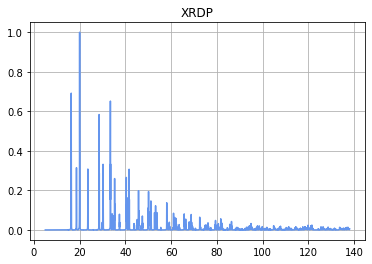

In [ ]:
print('sample:', sample, '\n',
      'crystal system:', dic_classes[y_train[sample]], '\n')
plt.plot(theta_2, train_x[sample], color='cornflowerblue')
plt.grid("on")
plt.title('XRDP');

<font size=4>
    
  The labels are numbers:

In [ ]:
y_train

array([3, 6, 1, ..., 0, 6, 0])

<font color='rosybrown'>
    
## One-hot encoding of target variable (y)

<font size=4>
    
    
The target value can have one of seven elements (classes), labeled with the digits: 0, 1, 2, 3, 4, 5, 6. 

The sets y_train and y_test are arrays in which each entry contains a digit represented as a integer of 64 bits.
    
We change this representation to a vector following the One-hot encoding 
[One-hot encoding](https://en.wikipedia.org/wiki/One-hot).
    
In One-Hot encoding, a digit is represented with a vector that has dimension 7 (because we have 7 classes) with 1.0 in the vector index corresponding to the digit and 0.0 elsewhere in the vector. 

In [ ]:
y_train.shape

(27440,)

<font size=4>
    
 [to_categorical](https://keras.io/api/utils/python_utils/#to_categorical-function)

In [ ]:
train_y = to_categorical(y_train, 7)
test_y = to_categorical(y_test, 7)

In [ ]:
train_y.shape

(27440, 7)

In [ ]:
y_train[0:5]

array([3, 6, 1, 0, 1])

In [ ]:
train_y[0:5]

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

<font color='rosybrown'>
    
## Viewing one sample from the data set.

sample: 20 
 crystal system in one-hot representation: [0. 0. 0. 0. 1. 0. 0.] 



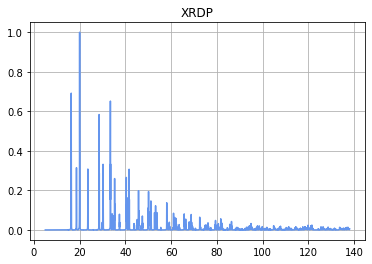

In [ ]:
print('sample:', sample, '\n',
      'crystal system in one-hot representation:', train_y[sample], '\n')
plt.plot(theta_2, train_x[sample], color='cornflowerblue')
plt.grid("on")
plt.title('XRDP');

<font size=4>
    
In summary, the training and test sample sets have the following dimensions:

In [ ]:
print ("number of training examples = " + str(train_x.shape[0]))
print ("number of test examples = " + str(test_x.shape[0]))
print ("X_train shape: " + str(train_x.shape))
print ("Y_train shape: " + str(train_y.shape))
print ("X_test shape: " + str(test_x.shape))
print ("Y_test shape: " + str(test_y.shape))

number of training examples = 27440
number of test examples = 560
X_train shape: (27440, 13301, 1)
Y_train shape: (27440, 7)
X_test shape: (560, 13301, 1)
Y_test shape: (560, 7)


<font size=5 color="cornflowerblue">

Building the Learning System

<font size=5 color='cornflowerblue'>

Definition of the neural network architecture

In [ ]:
def architecture(batch_normalization, dropout, input_shape, activation, num_classes):

    model = Sequential()
    
    model.add(Convolution1D(60, 100, strides = 5, padding ='same', input_shape=(13301,1))) #convolution layer
    if batch_normalization: 
        model.add(BatchNormalization())
    model.add(Activation(activation)) #activation
    if dropout: 
        model.add(Dropout(0.3))
    model.add(AveragePooling1D(pool_size=3, strides=2)) #pooling layer
    
    model.add(Convolution1D(60, 50, strides = 5, padding ='same'))
    if batch_normalization: 
        model.add(BatchNormalization())
    model.add(Activation(activation))
    if dropout: 
        model.add(Dropout(0.3))
    model.add(AveragePooling1D(pool_size=3, strides=None))
    
    model.add(Convolution1D(60,25 , strides = 2, padding ='same'))
    if batch_normalization: 
        model.add(BatchNormalization())
    model.add(Activation(activation))
    if dropout: 
        model.add(Dropout(0.3))
    model.add(AveragePooling1D(pool_size=3, strides=None))
    
    model.add(Flatten())
    
    model.add(Dense(700))
    if batch_normalization: 
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    if dropout: 
        model.add(Dropout(0.3))
        
    model.add(Dense(70))
    if batch_normalization: 
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    if dropout:     
        model.add(Dropout(0.3))
        
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model

<font size=5 color="cornflowerblue">

Building the neural network model for the learning system

In [ ]:
batch_normalization= False
dropout = True
input_shape = (13301,1)
num_classes = 7
activation = 'relu'

model = architecture(batch_normalization=batch_normalization, dropout=dropout, 
                     input_shape=input_shape, activation=activation, num_classes=num_classes)

<font size=5 color="cornflowerblue">
    
Graph of the model and summary

<font size=4> 
    
The 'plot_model()' function generates a graphic with the layers and their number of input ands output weights.
$$ $$
Documentation: [Model visualization](https://keras.io/visualization/#training-history-visualization)

In [ ]:
#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2661, 60)          6060      
_________________________________________________________________
activation (Activation)      (None, 2661, 60)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2661, 60)          0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 1330, 60)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 266, 60)           180060    
_________________________________________________________________
activation_1 (Activation)    (None, 266, 60)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 266, 60)           0

<font size=5 color='cornflowerblue'>
    
Optimization method

In [ ]:
learning_rate = 0.001

optimizer = keras.optimizers.Adam(lr=learning_rate)

<font size=4>
    
  [Adam optimizer in Keras](https://keras.io/api/optimizers/adam/)
  
  
  [Adam: A Method for Stochastic Optimization](literatura/Adam)

In [ ]:
loss_function = 'categorical_crossentropy'
metric_function = 'accuracy'

<font size=5 color='cornflowerblue'>
    
Compiling the model

In [ ]:
model.compile(loss=loss_function, 
              optimizer=optimizer,
              metrics=[metric_function])

<font size=5 color='cornflowerblue'>
    
Training the learning system

<font size=4 color="black">
    
Documentation: [keras.fit(...)](https://keras.io/models/model/#fit)

In [ ]:
validation_portion = 0.02
batch_size = 64
epochs = 70
start_time = time.time()
history_model = model.fit(train_x, train_y, 
                          batch_size=batch_size, 
                          epochs=epochs,
                          validation_split = validation_portion,
                          #validation_data=(dev_x, dev_y),
                          shuffle=True)

end_time = time.time()
print("Time for training: {:10.4f}s".format(end_time - start_time))

Epoch 1/70
421/421 [==============================] - 10s 23ms/step - loss: 1.4883 - accuracy: 0.4014 - val_loss: 1.1814 - val_accuracy: 0.5337
Epoch 2/70
421/421 [==============================] - 9s 22ms/step - loss: 1.1030 - accuracy: 0.5759 - val_loss: 0.9327 - val_accuracy: 0.6175
Epoch 3/70
421/421 [==============================] - 9s 22ms/step - loss: 0.8874 - accuracy: 0.6693 - val_loss: 0.6351 - val_accuracy: 0.7559
Epoch 4/70
421/421 [==============================] - 9s 22ms/step - loss: 0.7136 - accuracy: 0.7340 - val_loss: 0.5267 - val_accuracy: 0.8270
Epoch 5/70
421/421 [==============================] - 10s 23ms/step - loss: 0.5888 - accuracy: 0.7816 - val_loss: 0.4050 - val_accuracy: 0.8543
Epoch 6/70
421/421 [==============================] - 10s 23ms/step - loss: 0.5078 - accuracy: 0.8122 - val_loss: 0.3420 - val_accuracy: 0.8652
Epoch 7/70
421/421 [==============================] - 10s 23ms/step - loss: 0.4449 - accuracy: 0.8374 - val_loss: 0.2574 - val_accuracy: 0.

In [ ]:
loss = history_model.history['loss'][-1]
val_loss = history_model.history['val_loss'][-1]
acc = history_model.history['accuracy'][-1]
val_acc = history_model.history['val_accuracy'][-1]

title_acc = str(activation) + ', Adam, lr=' + str(learning_rate) + '\n' + 'acc_train: ' + \
        str(np.round(acc, 4)) + ', acc_val: ' + str(np.round(val_acc, 4))\
        + '\n' + 'BatchNorm=' + str(batch_normalization)\
        + '\n' + 'Dropout=' + str(dropout)


title_loss = str(activation) + ', Adam, lr=' + str(learning_rate) + '\n' +'loss_train: ' + \
        str(np.round(loss, 4)) + ', loss_val: ' + str(np.round(val_loss, 4))\
        + '\n' + 'BatchNorm=' + str(batch_normalization)\
        + '\n' + 'Dropout=' + str(dropout)

<font size=5 color="cornflowerblue">
    
Graph of cost functions as a function of epoch

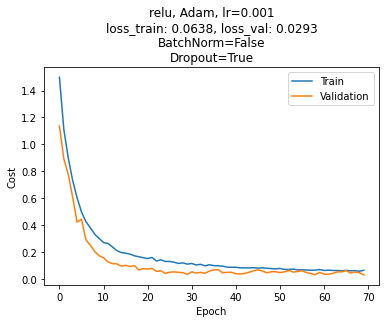

In [ ]:
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title(title_loss)
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right');

<font size=5 color="cornflowerblue">
    
Graph of accuracy functions as a function of epoch

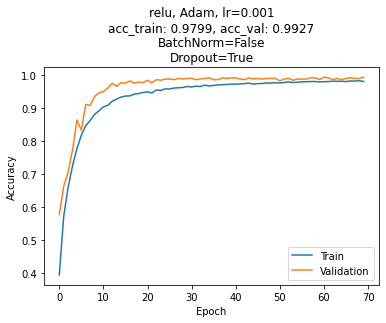

In [ ]:
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title(title_acc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right');

<font size = 5 color='cornflowerblue'>
    
Loss and accuracy evaluation

<font size= 4 color='black'>    
After training the network, the loss and accuracy functions are evaluated using the test samples (test_x, test_y).    

    
[Method evaluate in Keras](https://keras.io/models/model/)

In [ ]:
scores = model.evaluate(test_x, test_y)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

18/18 [==============================] - 0s 8ms/step - loss: 0.0475 - accuracy: 0.9893
Test loss: 0.0474981851875782
Test accuracy: 0.9892857074737549


In [ ]:
# Evaluation using the first 100 samples of the test set

evaluations = model.evaluate(x = test_x[:100], y = test_y[:100])

print ("Loss = " + str(evaluations[0]))
print ("Test Accuracy = " + str(evaluations[1]))

4/4 [==============================] - 0s 10ms/step - loss: 0.0286 - accuracy: 0.9900
Loss = 0.02857661247253418
Test Accuracy = 0.9900000095367432


<font size = 5 color='cornflowerblue'>
    
### Confusion Matrix

Confusion Matrix is a performance measurement for machine learning classification.

It is a performance measurement for machine learning classification problem where output can be two or more classes. It is a table with 4 different combinations of predicted and actual values.

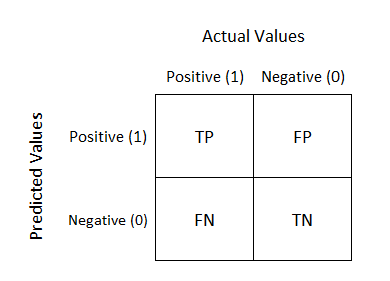

**True Positive**: You predicted positive and it’s true.


**True Negative**: You predicted negative and it’s true.


**False Positive**: (Type 1 Error) You predicted positive and it’s false.


**False Negative**: (Type 2 Error) You predicted negative and it’s false.


We describe predicted values as Positive and Negative and actual values as True and False.


**Recall**

Out of all the positive classes, how much we predicted correctly. It should be high as possible.

Recall = TP/(TP+FN)

**Precision**

Out of all the positive classes we have predicted correctly, how many are actually positive.

precision = TP/(TP+FP)


[Understanding Confusion Matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)

In [ ]:
y_target=np.argmax(test_y, axis=1)
predictions = model.predict(test_x)
y_pred = np.argmax(predictions, axis=1)

In [ ]:
dic_classes = {'triclinic': 0, 'monoclinic': 1, 'orthorhombic': 2, 
              'tetragonal': 3, 'trigonal': 4, 'hexagonal': 5, 'cubic': 6}

from sklearn.metrics import classification_report, confusion_matrix 
print('Confusion Matrix \n')
print(confusion_matrix(y_target, y_pred), '\n')
print('Classification Report \n ')
target_names = list(dic_classes.keys())
print(classification_report(y_target, y_pred, target_names=target_names))

Confusion Matrix 

[[86  0  0  0  0  0  0]
 [ 0 68  4  0  0  0  0]
 [ 0  0 77  1  0  0  0]
 [ 0  0  0 81  0  0  0]
 [ 0  0  0  0 74  0  0]
 [ 0  0  0  0  0 71  0]
 [ 0  0  1  0  0  0 97]] 

Classification Report 
 
              precision    recall  f1-score   support

   triclinic       1.00      1.00      1.00        86
  monoclinic       1.00      0.94      0.97        72
orthorhombic       0.94      0.99      0.96        78
  tetragonal       0.99      1.00      0.99        81
    trigonal       1.00      1.00      1.00        74
   hexagonal       1.00      1.00      1.00        71
       cubic       1.00      0.99      0.99        98

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560



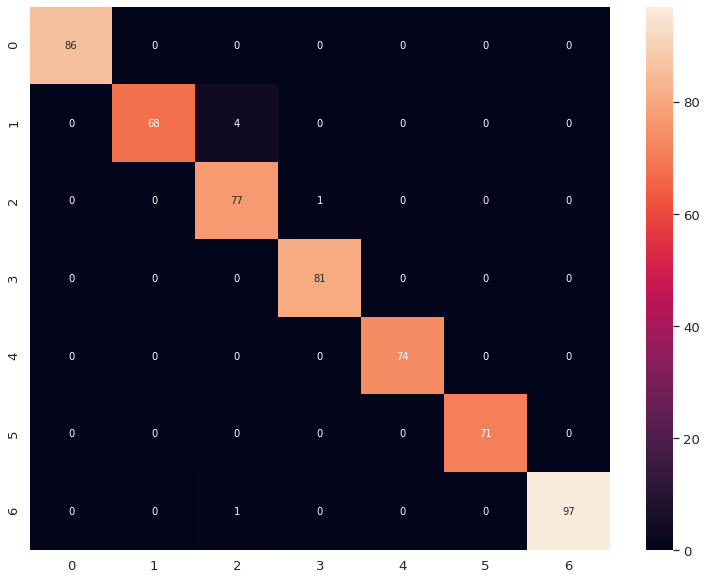

In [ ]:
import pandas as pd
import seaborn as sn 
plt.figure(figsize=(13,10))
snn_df_cm = pd.DataFrame(confusion_matrix(y_target, y_pred), range(7), range(7))  
#snn_df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred), range(7), range(7))  #para sparse
#plt.figure(figsize = (16,14))  
sn.set(font_scale=1.2) #for label size  
sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 10}) # font size  
#plt.savefig('matrix-impares.png'); 